In [12]:
 import pandas_datareader as pdr

In [13]:
import os

In [14]:
df = pdr.get_data_tiingo('GOOG', api_key='8c20d3dcb50744d14b97326576601d1289f0e07c')

In [15]:
df.to_csv('GOOG.csv')

In [16]:
import pandas as pd

In [17]:
df=pd.read_csv('GOOG.csv')

In [18]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2015-12-14 00:00:00+00:00,747.77,748.73,724.170,741.79,2421236,747.77,748.73,724.170,741.79,2421236,0.0,1.0
1,GOOG,2015-12-15 00:00:00+00:00,743.40,758.08,743.010,753.00,2666229,743.40,758.08,743.010,753.00,2666229,0.0,1.0
2,GOOG,2015-12-16 00:00:00+00:00,758.09,760.59,739.435,750.00,1993251,758.09,760.59,739.435,750.00,1993251,0.0,1.0
3,GOOG,2015-12-17 00:00:00+00:00,749.43,762.68,749.000,762.42,1553418,749.43,762.68,749.000,762.42,1553418,0.0,1.0
4,GOOG,2015-12-18 00:00:00+00:00,739.31,754.13,738.150,746.51,3148743,739.31,754.13,738.150,746.51,3148743,0.0,1.0


In [19]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,GOOG,2020-12-03 00:00:00+00:00,1826.77,1847.20,1822.6500,1824.01,1227298,1826.77,1847.20,1822.6500,1824.01,1227298,0.0,1.0
1253,GOOG,2020-12-04 00:00:00+00:00,1827.99,1833.16,1816.9900,1824.52,1378166,1827.99,1833.16,1816.9900,1824.52,1378166,0.0,1.0
1254,GOOG,2020-12-07 00:00:00+00:00,1819.48,1832.37,1805.7800,1819.00,1320946,1819.48,1832.37,1805.7800,1819.00,1320946,0.0,1.0
1255,GOOG,2020-12-08 00:00:00+00:00,1818.55,1821.90,1796.2047,1810.10,1096319,1818.55,1821.90,1796.2047,1810.10,1096319,0.0,1.0
1256,GOOG,2020-12-09 00:00:00+00:00,1784.13,1834.27,1767.8100,1812.01,1507558,1784.13,1834.27,1767.8100,1812.01,1507558,0.0,1.0


In [20]:
df1=df.reset_index()['close']

In [21]:
df1.shape

(1257,)

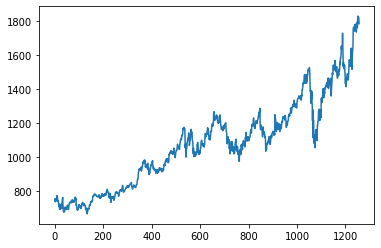

In [22]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [23]:
### LSTM are senstive to the scale data. so we apply MinMax scaler

In [24]:
import numpy as np

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [26]:
df1.shape

(1257, 1)

In [27]:
print(df1)

[[0.06855906]
 [0.06479094]
 [0.07745768]
 ...
 [0.99266209]
 [0.99186017]
 [0.96218085]]


In [28]:
### Spliting Data set into Train and Test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [29]:
training_size,test_size

(817, 440)

In [30]:
import numpy
#convert an array values into dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] ###i=0, 0,1,2,3
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [31]:
###reshape into X=t,t+1, t+2, t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [32]:
print(X_train)

[[0.06855906 0.06479094 0.07745768 ... 0.02366068 0.02860148 0.03695688]
 [0.06479094 0.07745768 0.06999043 ... 0.02860148 0.03695688 0.03849172]
 [0.07745768 0.06999043 0.06126426 ... 0.03695688 0.03849172 0.04735585]
 ...
 [0.38096798 0.36559372 0.3906254  ... 0.42216723 0.40961258 0.40876756]
 [0.36559372 0.3906254  0.38580532 ... 0.40961258 0.40876756 0.43760186]
 [0.3906254  0.38580532 0.3619032  ... 0.40876756 0.43760186 0.45263984]]


In [33]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [34]:
print(X_test.shape), print(ytest.shape)

(339, 100)
(339,)


(None, None)

In [35]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

In [36]:
### Creating the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [37]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [38]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Train on 716 samples, validate on 339 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
716/716 [==============================] - 4s 5ms/sample - loss: 0.0269 - val_loss: 0.0373
Epoch 2/100
716/716 [==============================] - 2s 3ms/sample - loss: 0.0061 - val_loss: 0.0153
Epoch 3/100
716/716 [==============================] - 2s 2ms/sample - loss: 0.0030 - val_loss: 0.0175
Epoch 4/100
716/716 [==============================] - 2s 2ms/sample - loss: 0.0013 - val_loss: 0.0058
Epoch 5/100
716/716 [==============================] - 2s 3ms/sample - loss: 0.0011 - val_loss: 0.0046
Epoch 6/100
716/716 [==============================] - 2s 2ms/sample - loss: 8.9514e-04 - val_loss: 0.0049
Epoch 7/100
716/716 [==============================] - 2s 2ms/sample - loss: 9.2737e-04 - val_loss: 0.0047
Epoch 8/100
716/716 [==============================] - 2s 2ms/sample - loss: 8.6728e-04 - val_loss: 0.0047
Epoch 9/100
716/716 [===

In [40]:
import tensorflow as tf

In [43]:
## Lets do the predictiona nd performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [45]:
## transform back to the original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [46]:
## Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

976.639472983143

In [47]:
## Test data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

1376.8628299558827

<function matplotlib.pyplot.show(*args, **kw)>

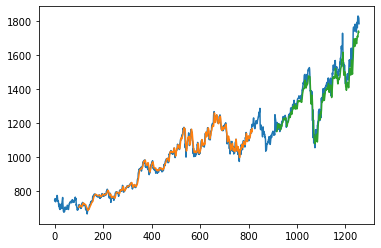

In [51]:
## Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
#shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
#plot baseline and prediction
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show

In [53]:
len(test_data)

440

In [52]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 99)

In [54]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [2]:
# Demonstrate Prediction for Next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if (len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day input {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print temp_input
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
        
print(lst_output)

NameError: name 'temp_input' is not defined